In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
# warnings.filterwarnings('ignore')

In [2]:
# ============================================================================
# GENEROWANIE DANYCH SYNTETYCZNYCH
# ============================================================================

def generate_call_center_data(start_date='2024-01-01', days=365):
    """
    Generuje syntetyczne dane polaczen do call center z niehomogenicznym
    procesem Poissona uwzgledniajacym rozne wzorce sezonowe.
    """
    np.random.seed(42)
    dates = pd.date_range(start=start_date, periods=days, freq='D')
    data = []
    
    for i, date in enumerate(dates):
        day_of_week = date.dayofweek
        day_of_year = date.dayofyear
        
        # 1. Trend wzrostowy (0.1 polaczenia/dzien)
        trend = 100 + i * 0.1
        
        # 2. Sezonowosc tygodniowa (mniej w weekendy)
        week_pattern = 0.6 if day_of_week in [5, 6] else 1.0
        
        # 3. Sezonowosc roczna (wiecej w Q1 i Q4)
        year_pattern = 1 + 0.3 * np.sin(2 * np.pi * day_of_year / 365)
        
        # 4. Efekt swiat
        is_holiday = (date.month == 12 and date.day == 25) or \
                     (date.month == 1 and date.day == 1)
        holiday_effect = 0.3 if is_holiday else 1.0
        
        # 5. Losowa zmiennosc
        random_effect = np.random.uniform(0.9, 1.1)
        
        # Laczna intensywnosc procesu Poissona
        lambda_t = trend * week_pattern * year_pattern * holiday_effect * random_effect
        
        # Generowanie liczby polaczen z rozkladu Poissona
        calls = np.random.poisson(lambda_t)
        
        data.append({
            'date': date,
            'calls': calls,
            'day_of_week': day_of_week,
            'day_of_year': day_of_year,
            'lambda': lambda_t
        })
    
    return pd.DataFrame(data)

data = generate_call_center_data()
print(data.head(5))
# plt.plot(data)


        date  calls  day_of_week  day_of_year      lambda
0 2024-01-01     31            0            1   29.398274
1 2024-01-02     97            1            2   94.175573
2 2024-01-03     83            2            3   91.995420
3 2024-01-04     90            3            4   95.888272
4 2024-01-05     95            4            5  101.587473


In [3]:
# ============================================================================
# METODA 0: nicnierobienie
# ============================================================================

def nicnierobienie(train):
    return train
   

In [4]:
# ============================================================================
# METRYKI JAKOSCI
# ============================================================================

def calculate_metrics(y_true, y_pred):
    """
    Oblicza metryki jakosci prognozy.
    """
    # print(y_true.shape)
    # print(y_pred.shape)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    # MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1))) * 100
    
    # R2
    r2 = r2_score(y_true, y_pred)
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2
    }

In [5]:
# ============================================================================
# WIZUALIZACJA
# ============================================================================

def plot_forecasts(test, predictions_dict):
    """
    Wizualizuje prognozy vs rzeczywiste wartosci.
    """
    plt.figure(figsize=(15, 8))
    
    # Wykres prognoz
    plt.subplot(2, 1, 1)
    plt.plot(test['date'], test['calls'], 'k-', linewidth=2, label='Rzeczywiste', alpha=0.7)
    
    colors = ['blue', 'green', 'purple']
    for i, (method_name, predictions) in enumerate(predictions_dict.items()):
        plt.plot(test['date'], predictions, '--', linewidth=2, 
                label=method_name, color=colors[i], alpha=0.7)
    
    plt.xlabel('Data', fontsize=12)
    plt.ylabel('Liczba polaczen', fontsize=12)
    plt.title('Porownanie metod prognozowania polaczen do call center', fontsize=14, fontweight='bold')
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Wykres bledow
    plt.subplot(2, 1, 2)
    for i, (method_name, predictions) in enumerate(predictions_dict.items()):
        errors = test['calls'].values - predictions
        plt.plot(test['date'], errors, '-', linewidth=1.5, 
                label=f'{method_name} (blad)', color=colors[i], alpha=0.7)
    
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    plt.xlabel('Data', fontsize=12)
    plt.ylabel('Blad prognozy', fontsize=12)
    plt.title('Bledy prognozowania', fontsize=14, fontweight='bold')
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('call_center_forecast.png', dpi=300, bbox_inches='tight')
    plt.show()


def plot_metrics_comparison(metrics_dict):
    """
    Wizualizuje porownanie metryk jakosci.
    """
    methods = list(metrics_dict.keys())
    metric_names = ['MAE', 'RMSE', 'MAPE', 'R2']
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    
    for i, metric in enumerate(metric_names):
        values = [metrics_dict[method][metric] for method in methods]
        
        bars = axes[i].bar(methods, values, color=['blue', 'green', 'purple'], alpha=0.7)
        axes[i].set_title(f'{metric}', fontsize=12, fontweight='bold')
        axes[i].set_ylabel('Wartosc', fontsize=10)
        axes[i].grid(True, alpha=0.3, axis='y')
        
        # Dodaj wartosci na slupkach
        for bar, value in zip(bars, values):
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width()/2., height,
                        f'{value:.2f}',
                        ha='center', va='bottom', fontsize=9)
        
        axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

PROGNOZOWANIE POLACZEN DO CALL CENTER
Niehomogeniczny proces Poissona

1. Generowanie syntetycznych danych...
   Wygenerowano 365 dni danych
   Zakres dat: 2024-01-01 do 2024-12-30
   Srednia liczba polaczen: 102.12
   Odchylenie standardowe: 29.19

2. Podzial danych:
   Zbior treningowy: 292 dni (2024-01-01 - 2024-10-18)
   Zbior testowy: 73 dni (2024-10-19 - 2024-12-30)
   Element testowy: 55

3. Generowanie prognoz...
292     55
293     63
294    100
295    107
296    104
Name: calls, dtype: int64
4. Metryki jakosci prognoz:

nicnierobienie:
  MAE (Mean Absolute Error):           0.00
  RMSE (Root Mean Squared Error):      0.00
  MAPE (Mean Absolute % Error):        0.00%
  R2 (Coefficient of Determination):   1.0000

6. Generowanie wykresow...


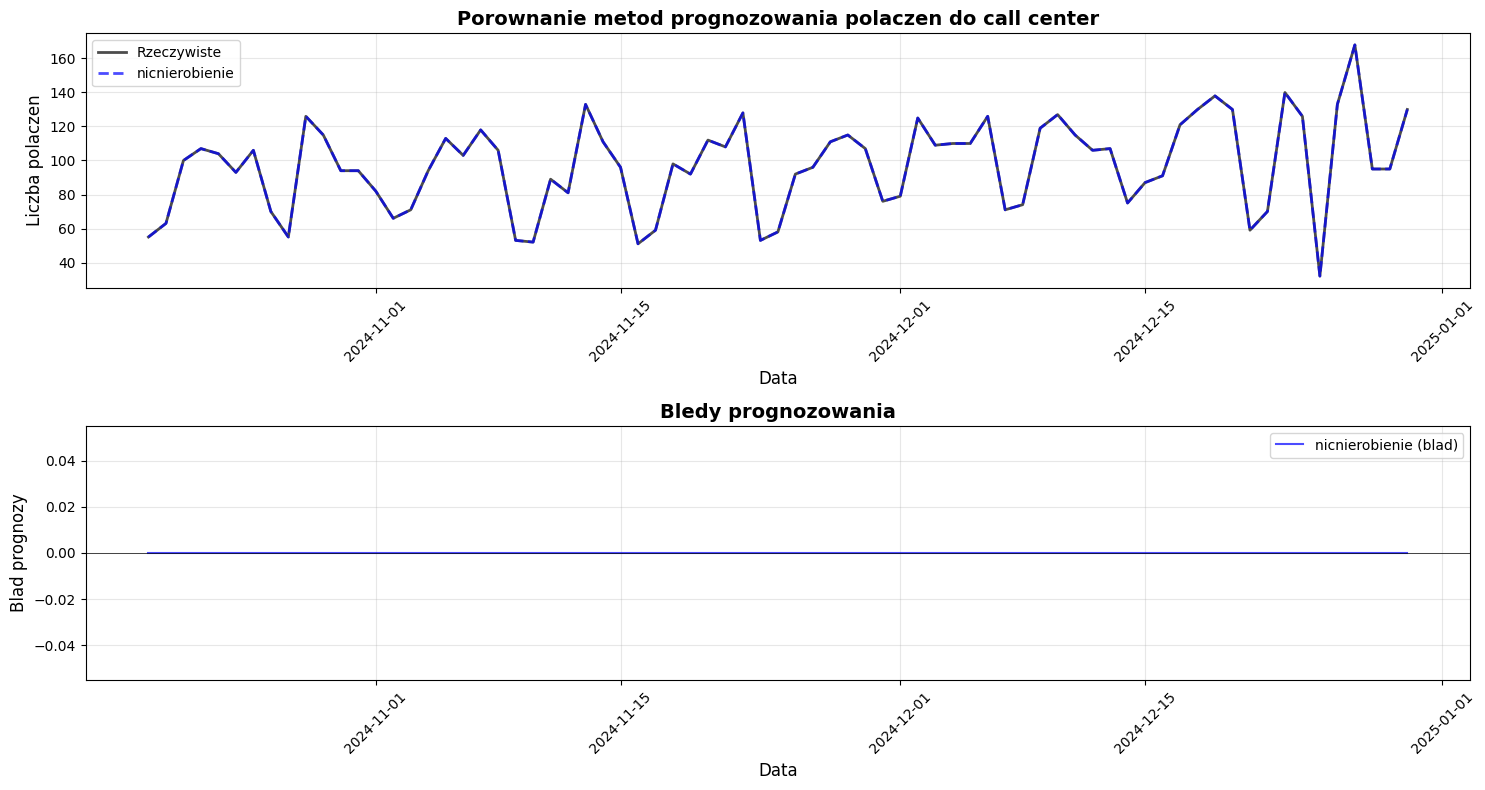

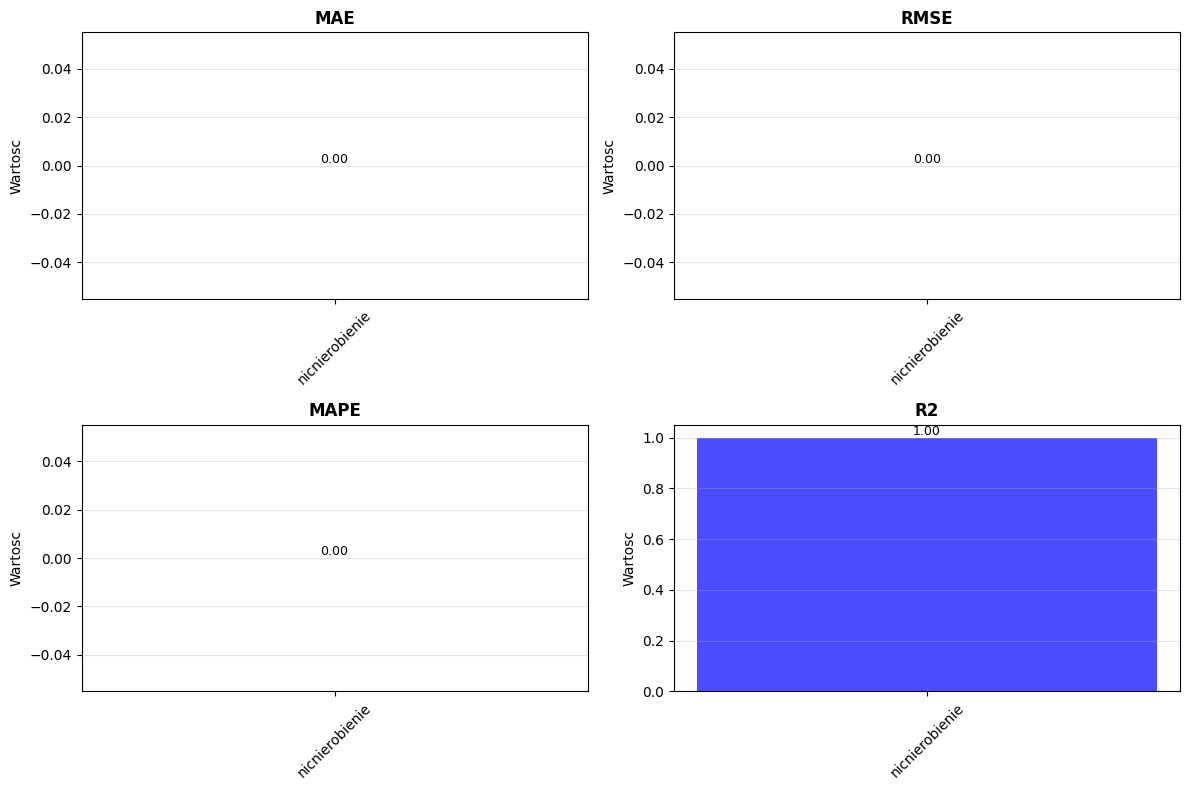

   Zapisano wykresy: call_center_forecast.png, metrics_comparison.png



In [6]:
# ============================================================================
# GLOWNA FUNKCJA
# ============================================================================

def main():
    print("="*80)
    print("PROGNOZOWANIE POLACZEN DO CALL CENTER")
    print("Niehomogeniczny proces Poissona")
    print("="*80)
    print()
    
    # 1. Generowanie danych
    print("1. Generowanie syntetycznych danych...")
    data = generate_call_center_data(days=365)
    print(f"   Wygenerowano {len(data)} dni danych")
    print(f"   Zakres dat: {data['date'].min().date()} do {data['date'].max().date()}")
    print(f"   Srednia liczba polaczen: {data['calls'].mean():.2f}")
    print(f"   Odchylenie standardowe: {data['calls'].std():.2f}")
    print()
    
    # 2. Podzial na zbior treningowy i testowy
    train_size = int(len(data) * 0.8)
    train = data.iloc[:train_size].copy()
    test = data.iloc[train_size:].copy()
    
    print("2. Podzial danych:")
    print(f"   Zbior treningowy: {len(train)} dni ({train['date'].min().date()} - {train['date'].max().date()})")
    print(f"   Zbior testowy: {len(test)} dni ({test['date'].min().date()} - {test['date'].max().date()})")
    print(f"   Element testowy: {test['calls'].iloc[0]}")
    print()

    
    
    # 3. Prognozowanie roznymi metodami
    print("3. Generowanie prognoz...")
    pred_nic = nicnierobienie(test['calls'])
    print(pred_nic.head(5))
    
    predictions_dict = {
        'nicnierobienie': pred_nic
    }
    
    
    # 4. Obliczanie metryk
    print("4. Metryki jakosci prognoz:")
    print("="*80)
    
    metrics_dict = {}
    y_true = test['calls'].values
    
    for method_name, predictions in predictions_dict.items():
        metrics = calculate_metrics(y_true, predictions)
        metrics_dict[method_name] = metrics
        
        print(f"\n{method_name}:")
        print(f"  MAE (Mean Absolute Error):           {metrics['MAE']:.2f}")
        print(f"  RMSE (Root Mean Squared Error):      {metrics['RMSE']:.2f}")
        print(f"  MAPE (Mean Absolute % Error):        {metrics['MAPE']:.2f}%")
        print(f"  R2 (Coefficient of Determination):   {metrics['R2']:.4f}")
    
    print("\n" + "="*80)
    
    
    # 6. Wizualizacja
    print("6. Generowanie wykresow...")
    plot_forecasts(test, predictions_dict)
    plot_metrics_comparison(metrics_dict)
    print("   Zapisano wykresy: call_center_forecast.png, metrics_comparison.png")
    print()

main()